# Logistic and linear regression with deterministic and stochastic first order methods

    Labs 3 : Optimisation - DataScience Master
    
   
The aim of this TP is to implement and compare various batch and stochastic algorithms for linear and logistic with ridge penalization. 
The following methods are compared in this notebook.

**Batch (deterministic) methods**
- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS
- conjugate gradient (CG)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.



In [309]:
# Change here using YOUR first and last names
fn1 = "daniel"
ln1 = "wamo"
fn2 = "samuel"
ln2 = "guilhem-ducleon"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp1_wamo_daniel_and_guilhem-ducleon_samuel.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [310]:
%matplotlib inline

In [311]:
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes

We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(x_i^\top \theta, y_i) + \frac \lambda 2 \|\theta\|_2^2
$$
where
- $\ell(z, y) = \frac 12 (y - z)^2$ (least-squares regression)
- $\ell(z, y) = \log(1 + \exp(-yz))$ (logistic regression).

We write it as a a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(\theta)
$$
where
$$
f_i(\theta) = \ell(x_i^\top \theta, y_i) + \frac \lambda 2 \|\theta\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(\theta) = (x_i^\top \theta - y_i) x_i + \lambda \theta
$$
and
$$
\nabla f_i(\theta) = - \frac{y_i}{1 + \exp(y_i x_i^\top \theta)} x_i + \lambda \theta.
$$

Denote by $L$ the Lipschitz constant of $f$ and by $L_i$ the Lipschitz constant of $f_i$. 
One can see easily that for linear regression
$$
L = \frac{ \|\mathbf X^\top \mathbf X \|_{\text{op}}}{n} + \lambda \quad \text{ and } L_i = \| x_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf X^\top \mathbf X \|_{\text{op}}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| x_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / \max_{i=1,\ldots,n} L_i$

We now introduce a class that will be used for the solvers.

In [312]:
from scipy.linalg import svd

class LinReg(object):
    """A class for the least-squares regression with
    Ridge penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda
    
    def grad(self, x):
        return A.T.dot(A.dot(x) - b) / self.n + self.lbda * x

    def loss(self, x):
        return norm(A.dot(x) - b) ** 2 / (2. * self.n) + self.lbda * norm(x) ** 2 / 2.
    
    def grad_i(self, i, x):
        a_i = A[i]
        return (a_i.dot(x) - b[i]) * a_i + self.lbda * x

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        L = np.max(svd(self.A, full_matrices=False)[1]) ** 2 / self.n + self.lbda
        return L

In [313]:
class LogReg(object):
    """A class for the logistic regression with L2 penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda
    
    def grad(self, x):
        bAx = self.b * np.dot(self.A, x)
        temp = 1. / (1. + np.exp(bAx))
        grad = - np.dot(A.T, self.b * temp) / self.n + self.lbda * x
        return grad

    def loss(self, x):
        bAx = self.b * np.dot(self.A, x)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * norm(x) ** 2 / 2.
    
    def grad_i(self, i, x):
        grad = - A[i] * self.b[i] / (1. + np.exp(self.b[i] * np.dot(self.A[i], x)))
        grad += self.lbda * x
        return grad

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        L = np.sum(np.max(self.A ** 2, axis=1)) / (4. * self.n) + self.lbda
        return L

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [314]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz

    
def simu_linreg(x, n, std=1., corr=0.5):
    """
    Simulation of the least-squares problem
    
    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the features matrix
    """    
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x_truth) + noise
    return A, b

In [315]:
def simu_logreg(x, n, std=1., corr=0.5):
    """
    Simulation of the logistic regression problem
    
    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the features matrix
    """    
    A, b = simu_linreg(x, n, std=1., corr=0.5)
    return A, np.sign(b)

In [316]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_truth = (-1) ** (idx - 1) * np.exp(-idx / 10.)

A, b = simu_linreg(x_truth, n, std=1., corr=0.7)

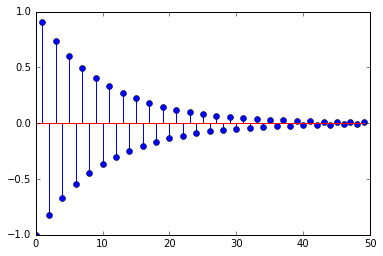

In [317]:
plt.stem(x_truth);

### Numerically check loss and gradient

In [318]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)
model = LinReg(A, b, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

1.2424146758012198e-06

In [319]:
lbda = 1. / n ** (0.5)
model = LogReg(A, b, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

2.7557528126841761e-07

### Choice of the model

In [320]:
#model = LinReg(A, b, lbda)
model = LogReg(A, b, lbda)

### Compute the theoretical step-size for FISTA

In [321]:
from scipy.linalg import svd

step = 1. / model.lipschitz_constant()

print("step = %s" % step)

step = 0.669362587091


### Get a very precise minimum to compute distances to minimum

In [322]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
print(f_min)

0.477354386728


<a id='batch'></a> 

## 3. Deterministic methods (ISTA, FISTA, BGFS)

Before implementing the logic of GD, ISTA or FISTA we provide a simple function to be called after each iteration to gather and display a few metrics about current the minimization process.

In [323]:
def inspector(loss_fun, x_real, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(xk):
        obj = loss_fun(xk) - f_min
        err = norm(xk - x_min)
        objectives.append(obj)
        errors.append(err)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    return inspector_cl

In [324]:
# Number of iterations
n_iter = 50

### ISTA

We recall that an iteration of ISTA (actually a batch gradient here) writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the Ista solver in the cell below

In [325]:
def ista(x_init, grad, n_iter=100, step=1., callback=None):
    """ISTA algorithm."""
    x = x_init.copy()
    
    for _ in range(n_iter):
        
        ### TODO
        x = x - step * grad(x)
        ### END TODO

        # Update metrics after each iteration.
        if callback: 
            callback(x)

    return x

In [326]:
step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
ista_inspector = inspector(model.loss, x_truth, verbose=True)
x_ista = ista(x_init, model.grad, n_iter, step, callback=ista_inspector)

   it    |   obj    |   err   
       0 | 1.53e-01 | 2.36e+00
      10 | 4.94e-02 | 1.56e+00
      20 | 2.43e-02 | 1.15e+00
      30 | 1.35e-02 | 8.82e-01
      40 | 7.91e-03 | 6.89e-01


### FISTA

We recall that an iteration of FISTA (actually an accelerated batch gradient here) writes

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the Fista solver in the cell below

In [327]:
import math

def fista(x_init, grad, n_iter=100, step=1., callback=None):
    """FISTA algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.

    for _ in range(n_iter):
        
        ### TODO
        x_old = x
        x = y - step * grad(y)
        t_old = t
        t = (1 + math.sqrt(1 + 4 * t**2))/2
        y = x + (t_old - 1)/t * (x - x_old)

        ### END TODO

        # Update metrics after each iteration.
        if callback: 
            callback(x)
    return x

In [328]:
step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
fista_inspector = inspector(model.loss, x_truth, verbose=True)
x_fista = fista(x_init, model.grad, n_iter, step, callback=fista_inspector)

   it    |   obj    |   err   
       0 | 1.53e-01 | 2.36e+00
      10 | 1.63e-02 | 9.63e-01
      20 | 7.44e-05 | 6.84e-02
      30 | 4.53e-04 | 1.76e-01
      40 | 6.07e-05 | 6.40e-02


### scipy.optimize's conjuguate gradient

Let's compare with ``scipy.optimize``'s conjuguate gradient solver.

In [329]:
# Conjugate gradient descent
from scipy.optimize import fmin_cg

x_init = np.zeros(d)
cg_inspector = inspector(model.loss, x_truth, verbose=True)
x_cg = fmin_cg(model.loss, x_init, model.grad, maxiter=n_iter, callback=cg_inspector)

   it    |   obj    |   err   
       0 | 1.46e-01 | 2.28e+00
      10 | 5.56e-05 | 4.83e-02
      20 | 1.36e-07 | 1.95e-03
Optimization terminated successfully.
         Current function value: 0.477354
         Iterations: 27
         Function evaluations: 54
         Gradient evaluations: 54


### scipy.optimize's BFGS

Let's compare with ``scipy.optimize``'s BFGS solver

In [330]:
# Conjugate gradient descent
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
bfgs_inspector = inspector(model.loss, x_truth, verbose=True)
x_bfgs, _, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, maxiter=n_iter, callback=bfgs_inspector)

   it    |   obj    |   err   
       0 | 2.05e-01 | 1.98e+00
      10 | 6.19e-05 | 4.62e-02
      20 | 1.10e-08 | 5.73e-04


### A first numerical comparison of deterministic solvers

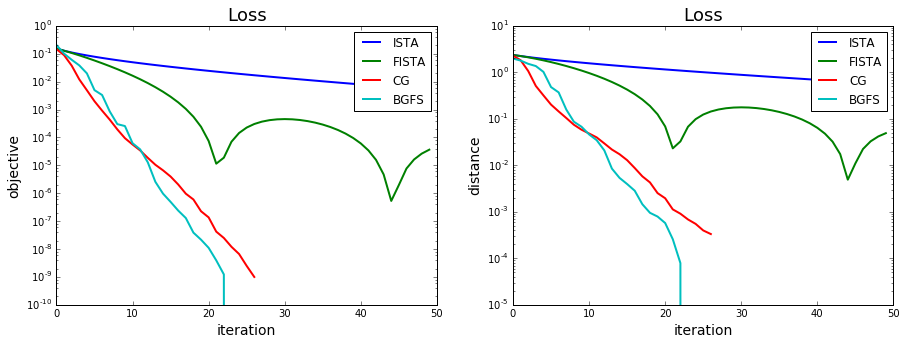

In [331]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector]

solvers = ["ISTA", "FISTA", "CG", "BGFS"]

for insp in inspectors:
    plt.plot(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("objective", fontsize=14)
    plt.yscale("log")

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.plot(insp.err, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("distance", fontsize=14)
    plt.yscale("log")

plt.legend(solvers);

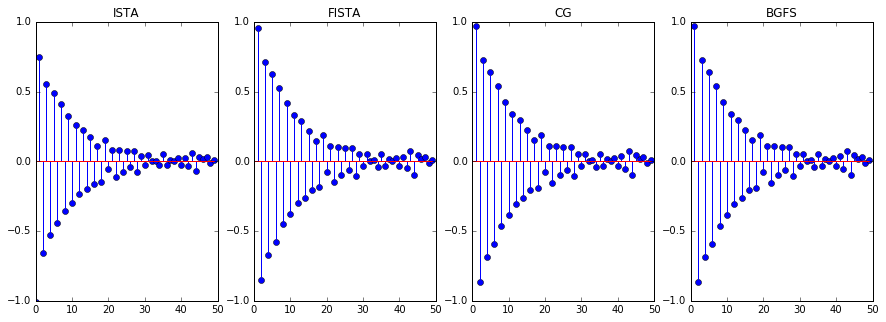

In [332]:
plt.figure(figsize=(15, 5))

xs = [x_ista, x_fista, x_cg, x_bfgs]

for i, name, x in zip(range(1, 5), solvers, xs):
    plt.subplot(1, 4, i)
    plt.stem(x)
    plt.ylim([-1, 1])
    plt.title(name)

### First conclusions

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here
- What do you observe about Fista, is it suprising ?

- We first observe that the Fista algorithm converges faster than the Ista algorithm.
Indeed the Nesterov theorem shows that the convergence rate of Fista is in $O(\frac{1}{k^2})$ where k is the number of iterations while the convergence is in $O(\frac{1}{k})$ for Ista.

- We can see that the Fista curve is made of bounces. This is because Fista is not a descent algorithm unlike Ista: at each iteration, while Ista always follows the slope of the convex function and makes the distance decrease, Fista looks for the steepest slope starting from a point between $x_k$ and $x_{k-1}$, i.e. $y_k$. Thus the distance to the minimum can slightly increase from time to time.

<a id='stoc'></a> 
## 4. Stochastic methods

In [333]:
n_iter = 50

# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)  

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [334]:
def sgd(x_init, iis, grad_i, n_iter=100, step=1., callback=None):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        
        x = x - step / (math.sqrt(idx + 1)) * grad_i(i, x)

        ### END TODO
        
        # Update metrics after each iteration.
        if callback and idx % n == 0:
            callback(x)
    return x

In [335]:
step0 = 1.
x_init = np.zeros(d)
sgd_inspector = inspector(model.loss, x_truth, verbose=True)
x_sgd = sgd(x_init, iis, model.grad_i, n * n_iter, step=step0, callback=sgd_inspector)

   it    |   obj    |   err   
       0 | 2.69e+00 | 4.60e+00
      10 | 4.09e-03 | 2.09e-01
      20 | 4.29e-03 | 1.80e-01
      30 | 1.96e-03 | 1.55e-01
      40 | 2.48e-03 | 1.62e-01


### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [336]:
def sag(x_init, iis, grad_i, n_iter=100, step=1., callback=None):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    y = np.zeros(d)
    G = np.zeros(d)

    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        
        #### IMPROVE COMPLEXITY
        #G = (1/n) * np.sum(gradient_memory, axis=0)
        
        tmp = grad_i(i, x)
        G = (n*G - gradient_memory[i] + tmp)/(n)
        gradient_memory[i, :] = tmp
        
        x = x - step * G

        ### END OF TODO
        
        # Update metrics after each iteration.
        if callback and idx % n == 0:
            callback(x)
    return x

In [337]:
max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))

if isinstance(model, LogReg):
    step = 4.0 / (max_squared_sum + 4.0 * model.lbda / model.n)
else:
    step = 1.0 / (max_squared_sum + model.lbda / model.n)

x_init = np.zeros(d)
sag_inspector = inspector(model.loss, x_truth, verbose=True)
x_sag = sag(x_init, iis, model.grad_i, n * n_iter, step, callback=sag_inspector)

   it    |   obj    |   err   
       0 | 2.16e-01 | 2.54e+00
      10 | 2.37e-03 | 1.50e-01
      20 | 2.63e-04 | 4.67e-02
      30 | 3.17e-05 | 1.48e-02
      40 | 2.18e-06 | 4.27e-03


### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [338]:
def svrg(x_init, iis, grad, grad_i, n_iter, step, callback=None):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    
    #mean = np.zeros(d)
    
    for idx in range(n_iter):
        
        ### TODO
        if idx % n == 0:
            x_tilde = x_old
            x = x_tilde.copy()
        
            mu = grad(x_tilde)
        
        i = iis[idx]
        x = x - step * (grad_i(i, x) - grad_i(i, x_tilde) + mu)
        x_old = x
        
        #mean += x
            
            

        
        ### END TODO        
        
        # Update metrics after each iteration.
        if callback and idx % n == 0:
            callback(x)
    return x

In [339]:
#step = 1. / (20. * model.lipschitz_constant())

if isinstance(model, LogReg):
    step = 4.0 / (max_squared_sum + 4.0 * model.lbda / model.n)
else:
    step = 1.0 / (max_squared_sum + model.lbda / model.n)

x_init = np.zeros(d)
svrg_inspector = inspector(model.loss, x_truth, verbose=True)    
x_svrg = svrg(x_init, iis, model.grad, model.grad_i, n * n_iter, step, callback=svrg_inspector)

   it    |   obj    |   err   
       0 | 2.12e-01 | 2.53e+00
      10 | 2.79e-06 | 5.25e-03
      20 | -1.08e-10 | 1.60e-04
      30 | -7.33e-10 | 1.43e-04
      40 | -7.33e-10 | 1.43e-04


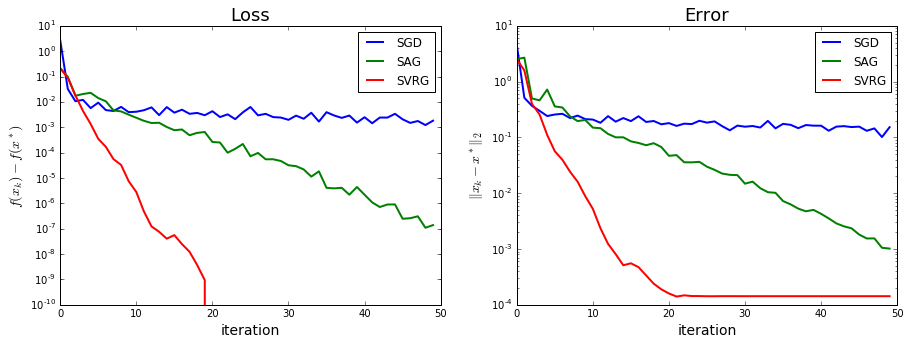

In [340]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.plot(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.plot(insp.err, lw=2)
    plt.title("Error", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers);

<a id='comp'></a> 
## 5. Numerical comparison

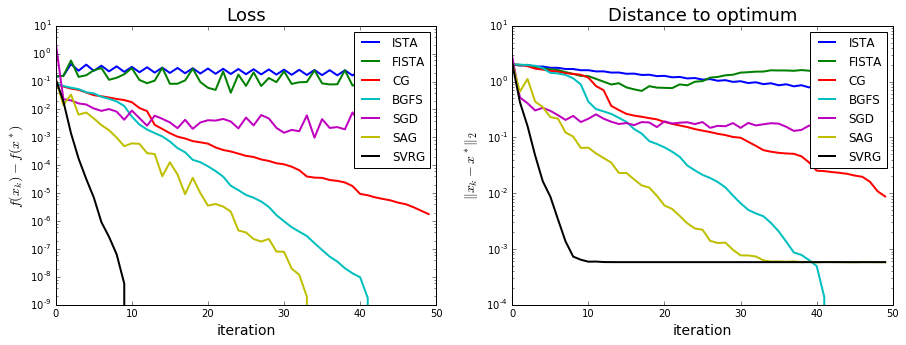

In [372]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector,
              sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["ISTA", "FISTA", "CG", "BGFS", "SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.plot(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.plot(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers);

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:
- Compare and comment your results
- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Conclude

- Question: Compare and comment your results

SGD is very fast in the first iterations.

SGD struggles to find an accurate solution as soon as the distance to the real minimum is small enough. This is because stochastic gradients don't have bias but have a large variance.

SAG and SVRG both find a more accurate minimum. Indeed the two techniques both use variance reduction techniques to reduce the variance of the SGD algorithm. Here, SVRG seems to be faster than SAG but it is difficult to compare them generally.

Those last techniques are much faster than full gradient descent (ista).

- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.

The graph above was with $\lambda = \frac{1}{\sqrt n}$.

Let's draw the graph for $\lambda = \frac{1}{n}$.

NB: we tried to make a beautiful function instead of copying the following code multiple times but the graphs were not drawn properly.

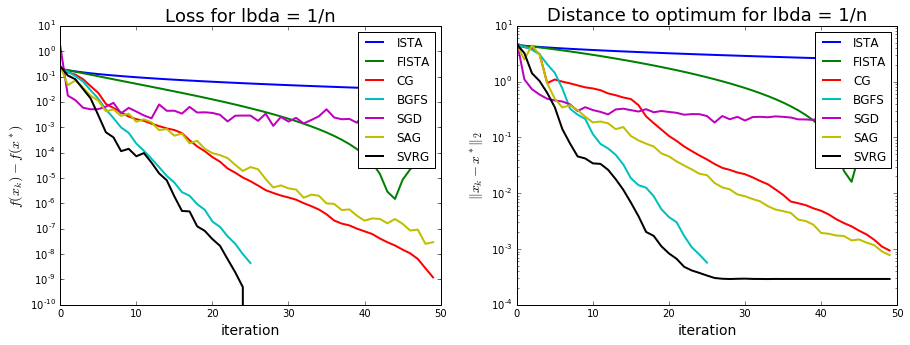

In [355]:
verbose = False
lbda = 1. / n

d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_truth = (-1) ** (idx - 1) * np.exp(-idx / 10.)

A, b = simu_linreg(x_truth, n, std=1., corr=0.7)

model = LogReg(A, b, lbda)

step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)

n_iter = 50

step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
ista_inspector = inspector(model.loss, x_truth, verbose=verbose)
x_ista = ista(x_init, model.grad, n_iter, step, callback=ista_inspector)


step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
fista_inspector = inspector(model.loss, x_truth, verbose=verbose)
x_fista = fista(x_init, model.grad, n_iter, step, callback=fista_inspector)

x_init = np.zeros(d)
cg_inspector = inspector(model.loss, x_truth, verbose=verbose)
x_cg = fmin_cg(model.loss, x_init, model.grad, maxiter=n_iter, callback=cg_inspector, disp=verbose)

x_init = np.zeros(d)
bfgs_inspector = inspector(model.loss, x_truth, verbose=verbose)
x_bfgs, _, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, maxiter=n_iter, callback=bfgs_inspector)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector]

solvers = ["ISTA", "FISTA", "CG", "BGFS"]
xs = [x_ista, x_fista, x_cg, x_bfgs]

n_iter = 50
iis = np.random.randint(0, n, n * n_iter)

step0 = 1.
x_init = np.zeros(d)
sgd_inspector = inspector(model.loss, x_truth, verbose=verbose)
x_sgd = sgd(x_init, iis, model.grad_i, n * n_iter, step=step0, callback=sgd_inspector)

max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))

if isinstance(model, LogReg):
    step = 4.0 / (max_squared_sum + 4.0 * model.lbda / model.n)
else:
    step = 1.0 / (max_squared_sum + model.lbda / model.n)

x_init = np.zeros(d)
sag_inspector = inspector(model.loss, x_truth, verbose=verbose)
x_sag = sag(x_init, iis, model.grad_i, n * n_iter, step, callback=sag_inspector)

if isinstance(model, LogReg):
    step = 4.0 / (max_squared_sum + 4.0 * model.lbda / model.n)
else:
    step = 1.0 / (max_squared_sum + model.lbda / model.n)

x_init = np.zeros(d)
svrg_inspector = inspector(model.loss, x_truth, verbose=verbose)    
x_svrg = svrg(x_init, iis, model.grad, model.grad_i, n * n_iter, step, callback=svrg_inspector)

inspectors = [sgd_inspector, sag_inspector, svrg_inspector]
solvers = ["SGD", "SAG", "SVRG"]

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector,
              sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["ISTA", "FISTA", "CG", "BGFS", "SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.plot(insp.obj, lw=2)
    plt.title("Loss for lbda = 1/n", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.plot(insp.err, lw=2)
    plt.title("Distance to optimum for lbda = 1/n", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers);

With $1 \over n$ in front of the ridge term, we penalize less than with $1 \over \sqrt n$. Therefore there is more variance and less bias in the loss we want to minimize.

We observe that the convergence is slower for SVRG and SAG when the lbda is $1\over n$ in the ridge penalty. Indeed we have more variance and SVRG and SAG perform better with more bias.

We also have less irregularities in the Fista curve: the number of bounces has decreased.

- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.

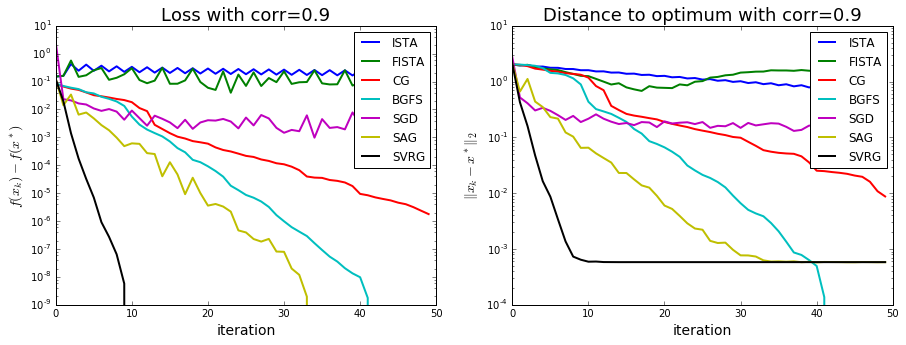

In [370]:
corr = 0.9

verbose = False
lbda = 1. / n ** 0.5

d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_truth = (-1) ** (idx - 1) * np.exp(-idx / 10.)

A, b = simu_linreg(x_truth, n, std=1., corr=corr)

model = LogReg(A, b, lbda)

step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)

n_iter = 50

step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
ista_inspector = inspector(model.loss, x_truth, verbose=verbose)
x_ista = ista(x_init, model.grad, n_iter, step, callback=ista_inspector)


step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
fista_inspector = inspector(model.loss, x_truth, verbose=verbose)
x_fista = fista(x_init, model.grad, n_iter, step, callback=fista_inspector)

x_init = np.zeros(d)
cg_inspector = inspector(model.loss, x_truth, verbose=verbose)
x_cg = fmin_cg(model.loss, x_init, model.grad, maxiter=n_iter, callback=cg_inspector, disp=verbose)

x_init = np.zeros(d)
bfgs_inspector = inspector(model.loss, x_truth, verbose=verbose)
x_bfgs, _, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, maxiter=n_iter, callback=bfgs_inspector)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector]

solvers = ["ISTA", "FISTA", "CG", "BGFS"]
xs = [x_ista, x_fista, x_cg, x_bfgs]

n_iter = 50
iis = np.random.randint(0, n, n * n_iter)

step0 = 1.
x_init = np.zeros(d)
sgd_inspector = inspector(model.loss, x_truth, verbose=verbose)
x_sgd = sgd(x_init, iis, model.grad_i, n * n_iter, step=step0, callback=sgd_inspector)

max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))

if isinstance(model, LogReg):
    step = 4.0 / (max_squared_sum + 4.0 * model.lbda / model.n)
else:
    step = 1.0 / (max_squared_sum + model.lbda / model.n)

x_init = np.zeros(d)
sag_inspector = inspector(model.loss, x_truth, verbose=verbose)
x_sag = sag(x_init, iis, model.grad_i, n * n_iter, step, callback=sag_inspector)

if isinstance(model, LogReg):
    step = 4.0 / (max_squared_sum + 4.0 * model.lbda / model.n)
else:
    step = 1.0 / (max_squared_sum + model.lbda / model.n)

x_init = np.zeros(d)
svrg_inspector = inspector(model.loss, x_truth, verbose=verbose)    
x_svrg = svrg(x_init, iis, model.grad, model.grad_i, n * n_iter, step, callback=svrg_inspector)

inspectors = [sgd_inspector, sag_inspector, svrg_inspector]
solvers = ["SGD", "SAG", "SVRG"]

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector,
              sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["ISTA", "FISTA", "CG", "BGFS", "SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.plot(insp.obj, lw=2)
    plt.title("Loss with corr=" + str(corr), fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.plot(insp.err, lw=2)
    plt.title("Distance to optimum with corr=" + str(corr), fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers)
plt.savefig('corr' + str(corr) + '.png')

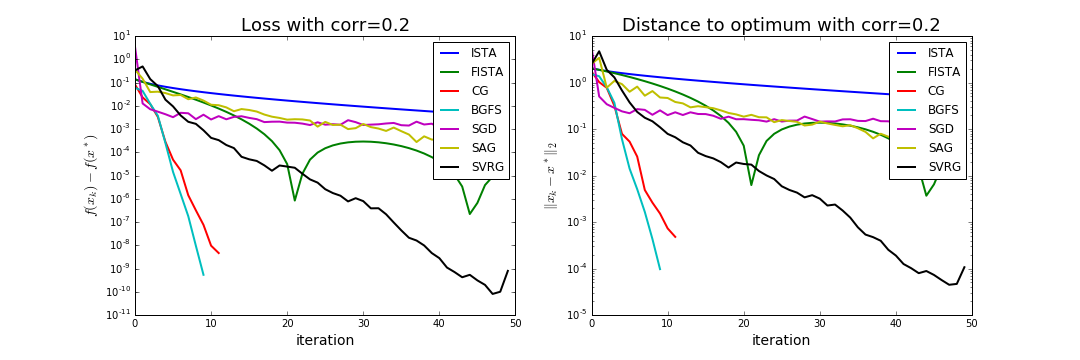

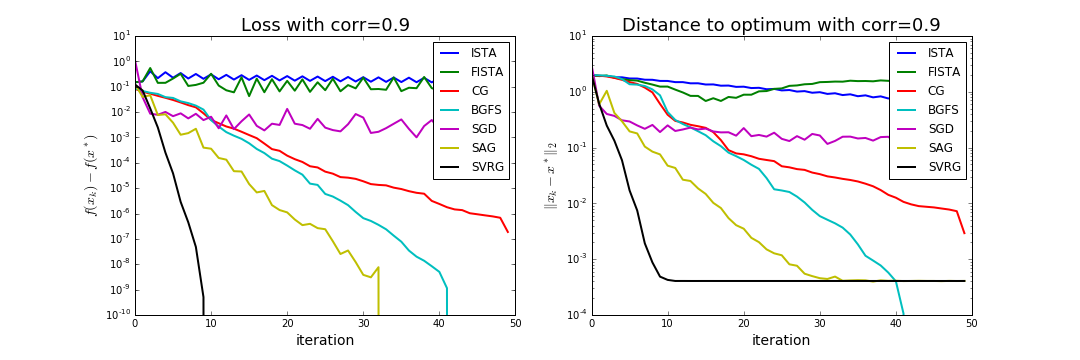

In [369]:
from IPython.display import Image, display
display(Image(filename = 'corr0.2.png'))
display(Image(filename = 'corr0.9.png'))

SVRG and SAG perform better with a high correlation than with a low correlation.

Indeed, when the correlation between the features is very high, each time we pick a random i for the SAG algorithm, we always have the same feature. So the higher the correlation, the lower the variance. The conclusion is the same for SVRG.

There are much more irregularities with a high correlation because at each iteration, we pick a new random feature (or direction), which is actually almost the same that the previous one as all features are highly correlated, and thus the descent is more difficult as we have to do the same work than with the previous feature.

With a high correlation, the Fista algorithm is not better than Ista.

- Conclude

As a conclusion, we can say that SAG and SVRG are much more efficient when there is a high correlation between the features and a high penalization. The less variance the better.